[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shadowcz007/one-shot-talking-face-colab/blob/main/one_shot_talking_face.ipynb)

In [1]:
# 初始化，安装各种依赖和下载模型
!git lfs install
%cd /content
!git clone https://huggingface.co/camenduru/pocketsphinx-20.04-t4 pocketsphinx
%cd  /content/pocketsphinx
!sudo cmake --build build --target install
%cd /content
!git clone https://huggingface.co/camenduru/one-shot-talking-face-20.04-t4 one-shot-talking-face
%cd /content/one-shot-talking-face
!pip install -r /content/one-shot-talking-face/requirements.txt
!chmod 755 /content/one-shot-talking-face/OpenFace/FeatureExtraction
!mkdir /content/out
!apt install -qq libgtk2.0-0 jq -y
!pip install -q imageio-ffmpeg

!pip install face_recognition

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
/content
Cloning into 'pocketsphinx'...
remote: Enumerating objects: 1658, done.
remote: Total 1658 (delta 0), reused 0 (delta 0), pack-reused 1658
Receiving objects: 100% (1658/1658), 8.51 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (592/592), done.
/content/pocketsphinx
-- SIZEOF_LONG="8" ; SIZEOF_LONG_LONG="8"
-- WORDS_BIGENDIAN="0"
-- SPHINX_DEBUG="" ; DEBUG_ENDIAN=""
-- FIXED_POINT="OFF" ; DEFAULT_RADIX="12"
-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- Checking for module 'libpulse-simple'
--   No package 'libpulse-simple' found
-- Checking for module 'portaudio-2.0'
--   No package 'portaudio-2.0' found
-- MODELDIR="/usr/local/share/pocketsphinx/model"
-- Configuring done
-- Generating done
-- Build files have been written to: /content/pocketsphinx/build
Scanning dependencies of target pocketsphinx
[  0%] Building C object src/CMakeFiles/pocketsphinx.dir/acmod.c.o
[  0%] Buildi

In [12]:
#裁切人脸

from PIL import Image
import face_recognition

def crop_face_image(image_path,output):
    # Load the jpg file into a numpy array
    image = face_recognition.load_image_file(image_path)

    # Find all the faces in the image using the default HOG-based model.
    # This method is fairly accurate, but not as accurate as the CNN model and not GPU accelerated.
    # See also: find_faces_in_picture_cnn.py
    face_locations = face_recognition.face_locations(image)

    print("I found {} face(s) in this photograph.".format(len(face_locations)))

    if len(face_locations)==1:
      top, right, bottom, left = face_locations[0]
      
      width=((right-left)*1.6)
      height=((bottom-top)*1.6)
      padding=(height+top-bottom)/2
      bottom=int(bottom+padding)
      top=max(int(top-padding),0)
      left=max(int(left-padding),0)
      right=int(right+padding)
      print(
          "Top: {}, Left: {}, width: {}, height: {}".format(
              top, 
              left, 
              right-left,
              bottom-top))


      # You can access the actual face itself like this:
      face_image = image[top:bottom, left:right]
      pil_image = Image.fromarray(face_image)
      pil_image.save(output)

/content/my


Saving 截屏2023-01-29 18.46.00.png to 截屏2023-01-29 18.46.00 (1).png
I found 1 face(s) in this photograph.
Top: 0, Left: 73, width: 514, height: 480



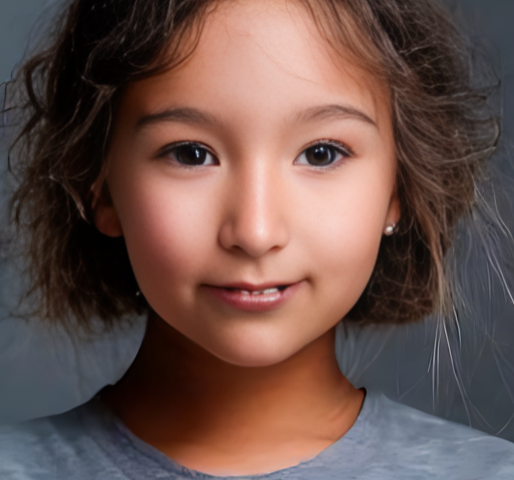

In [13]:
# 上传文件
import os
from IPython.display import HTML
from base64 import b64encode


root_dir = "/content/my" #@param {type:"string"}
if not os.path.exists(root_dir):
  os.mkdir(root_dir)
os.chdir(root_dir)
!pwd

from google.colab import files
uploaded=files.upload()

for filename in uploaded.keys():
  fn=filename.lower()
  if '.wav' in fn:
    os.rename(root_dir+'/'+filename,root_dir+'/audio.wav')
  if '.png' in fn or '.jpg' in fn or '.jpeg' in fn:
    crop_face_image(root_dir+'/'+filename,root_dir+'/face.png')
    # os.rename(root_dir+'/'+filename,root_dir+'/face.png')

def show_image(img_path, img_width = 256):
  img_path = open(img_path, "r+b").read()
  img_url = f"data:image/png;base64,{b64encode(img_path).decode()}"
  return HTML(f"""<img width={img_width} src="{img_url}"/>""")
  
show_image(root_dir+'/face.png')

In [14]:
import os, random, torchaudio

from IPython.display import clear_output

def show_video(video_path, video_width = 256):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

wav_file = root_dir+'/audio.wav'  
image_file = root_dir+'/face.png'

waveform, sample_rate = torchaudio.load(wav_file)
torchaudio.save(wav_file, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16)

os.environ['wav_file'] = wav_file
os.environ['image_file'] = image_file
random_int = str(random.randint(1, 1000000))

!mkdir /content/train
!cp $wav_file /content/train/audio.wav
!cp $image_file /content/train/image.png

!pocketsphinx -phone_align yes single /content/train/audio.wav $text | jq '[.w[]|{word: (.t | ascii_upcase | sub("<S>"; "sil") | sub("<SIL>"; "sil") | sub("\\(2\\)"; "") | sub("\\(3\\)"; "") | sub("\\(4\\)"; "") | sub("\\[SPEECH\\]"; "SIL") | sub("\\[NOISE\\]"; "SIL")), phones: [.w[]|{ph: .t | sub("\\+SPN\\+"; "SIL") | sub("\\+NSN\\+"; "SIL"), bg: (.b*100)|floor, ed: (.b*100+.d*100)|floor}]}]' > /content/test.json
%cd /content/one-shot-talking-face
!python -B test_script.py --img_path /content/train/image.png --audio_path /content/train/audio.wav --phoneme_path /content/test.json --save_dir /content/train

os.environ['ran_num'] = random_int
!cp /content/train/image_audio.mp4 "/content/out/${ran_num}.mp4"

clear_output()

show_video(f"/content/out/{random_int}.mp4")